In [67]:
# !pip install wordcloud

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import string
import re
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## Train File EDA

In [69]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [71]:
# Explore the label size
columns=train.columns

size_list = []
for n in range(2,len(columns)):
    size = train[columns[n]].value_counts().to_frame()
    size_list.append(size)

size_table=pd.concat(size_list,axis=1)
size_table

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


<AxesSubplot:>

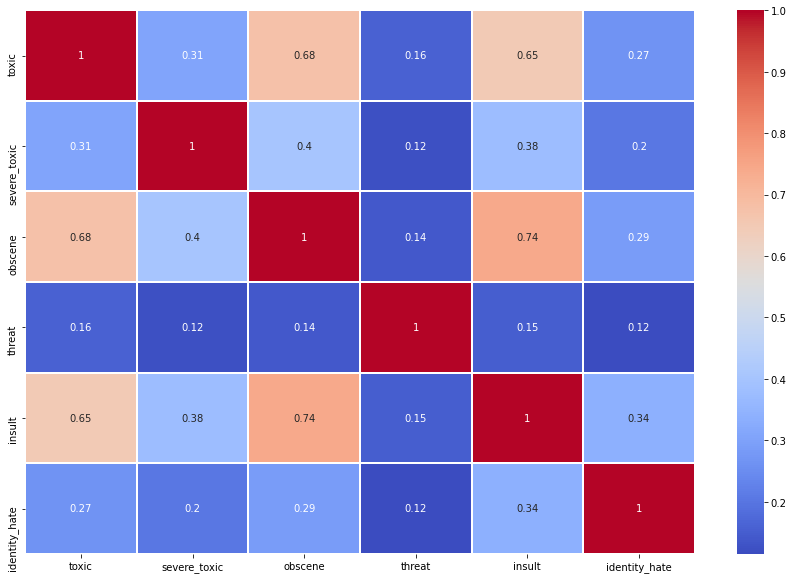

In [72]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True,linewidths=1)

In [73]:
PosNeg=[]
for i in columns[2:]:
    df = train[i].value_counts().to_frame()
    PosNeg.append(df)

pd.concat(PosNeg,axis=1)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [74]:
cm = []
for n in range(3,len(columns)):
    
    table = pd.crosstab(train[columns[2]], train[columns[n]])
    cm.append(table)

cm_table=pd.concat(cm,axis=1,keys=columns[3:])
cm_table

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

In [75]:
# Find Out the Total Number for Different Tags 
train.iloc[:,2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [76]:
# Sum the Number of Tags for Each Row
rowsum = train.iloc[:,2:].sum(axis=1)

In [77]:
# Create a Column Named Clean if There is No Bad Tags in a Comment
train['clean']= (rowsum == 0).astype(int)

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [78]:
# Find Out the Total Number for Different Tags Again

tag = train.iloc[:,2:].sum(axis=0)
tag

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
clean            143346
dtype: int64

C:\Users\LZJ1995\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Numbers of text')

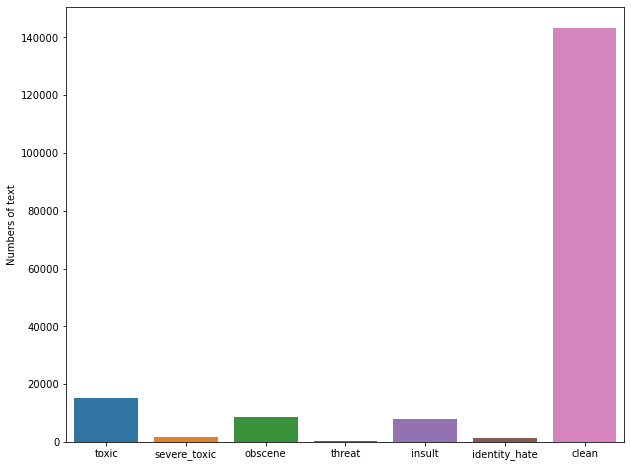

In [79]:
plt.figure(figsize=(10,8))
sns.barplot(tag.index, tag.values)
label=tag.values

plt.ylabel('Numbers of text')

Text(0, 0.5, 'Numbers of Text')

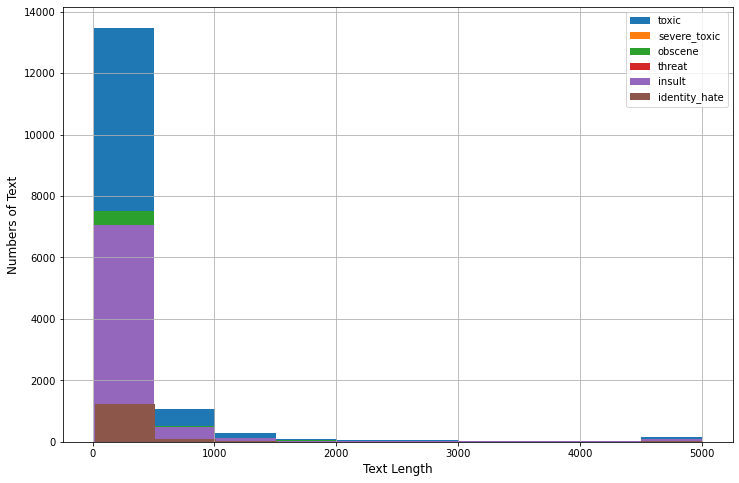

In [80]:
for i in range(2,len(columns)):
    train[train[columns[i]]==1]['comment_text'].str.len().hist(label=columns[i],figsize=(12,8))

plt.legend()
plt.xlabel('Text Length',fontsize=12)
plt.ylabel('Numbers of Text',fontsize=12)

In [81]:
x=rowsum.value_counts()
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

C:\Users\LZJ1995\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Numbers of Text')

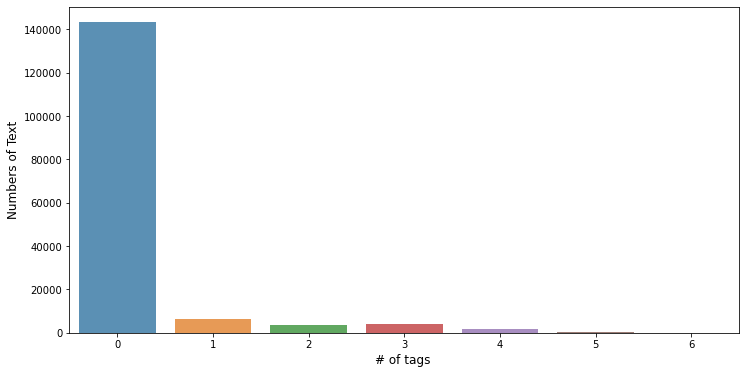

In [82]:
plt.figure(figsize=(12,6))
sns.barplot(x.index, x.values, alpha=0.8)

plt.xlabel('# of tags ', fontsize=12)
plt.ylabel('Numbers of Text',fontsize=12)

In [83]:
#Explore Comment Text

for i in range(15):
    print("Sentence number ", i+1)
    print(train['comment_text'][i])
    print("length of the text:", len(train['comment_text'][i]))
    print('\n')

Sentence number  1
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
length of the text: 264


Sentence number  2
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
length of the text: 112


Sentence number  3
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
length of the text: 233


Sentence number  4
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact s

In [84]:
#wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)

In [85]:
train[train['comment_text'].str.contains("\n")].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0,1
11,00054a5e18b50dd4,bbq \n\nbe a man and lets discuss it-maybe ove...,0,0,0,0,0,0,1


In [86]:
train[train['comment_text'].str.contains("http")].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
22,000c0dfd995809fa,"""\n\n Snowflakes are NOT always symmetrical! \...",0,0,0,0,0,0,1
33,001363e1dbe91225,I was able to post the above list so quickly b...,0,0,0,0,0,0,1
73,002c9cccf2f1d05b,"""\n Ambiguous ? \nSo Mabuska Irish can mean mo...",0,0,0,0,0,0,1
91,0038f191ffc93d75,Transliteration of Russian place names\nIn wri...,0,0,0,0,0,0,1
101,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,0,0,0,1


In [87]:
train[train['comment_text'].str.contains("https")].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
91,0038f191ffc93d75,Transliteration of Russian place names\nIn wri...,0,0,0,0,0,0,1
363,00e769033b3844a7,""" , I and —Preceding undated comment added ...",0,0,0,0,0,0,1
518,015b9724dd4e05cd,"""\n\nBaer didnt invent video games. This is je...",0,0,0,0,0,0,1
528,0162a0b1626f7099,"""\n\nAfican Union site vandalism\n\nDear Brack...",0,0,0,0,0,0,1
635,01b6cca55becc58b,"""\n\n Philosopher RFC \nphilosopher (from Wikt...",0,0,0,0,0,0,1


In [88]:
train[train['comment_text'].str.contains("http")]['comment_text'][518]

'"\n\nBaer didnt invent video games. This is jewish propaganda supported by a wiki troll named, ""Goldberg"" Go figure. \n\nHey, ""goldberg"", try educating yourself. \n\nhttps://www.youtube.com/watch?v=EfBwz_SiK8s"'

In [89]:
train[train['comment_text'].str.contains("@")].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1,0
437,011d0c0a6c8e5765,I NEVER FUCKING MADE THIS MOTHER FUCKING ARTIC...,1,0,1,0,1,0,0
638,01b9aa85cc61c03f,"""\n\n You Suck \n\nIf you don't undelete the p...",1,0,1,0,1,0,0
814,0229d0cd9a4603df,"Amazing, thank you very much! @",0,0,0,0,0,0,1


## Text Preprocessing

In [90]:
# Duplicate the Train DataFrame
train_data = train.copy()
train_data = train_data.drop(columns='clean')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [91]:
# import the Test DataFrame
test = pd.read_csv('test.csv')

test_label = pd.read_csv('test_labels.csv')

test_data = test.merge(test_label,on='id',how='left')
test_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [92]:
PosNegT=[]
for i in columns[2:]:
    df = test_data[i].value_counts().to_frame()
    PosNegT.append(df)

pd.concat(PosNegT,axis=1)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
-1,89186,89186,89186,89186,89186,89186
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


In [93]:
# Separate Between Scored and Unscored Data

val_data = test_data[(test_data['toxic']!=-1)|(test_data['severe_toxic']!=-1)|(test_data['obscene']!=-1)|\
                     (test_data['threat']!=-1)|(test_data['insult']!=-1)|(test_data['identity_hate']!=-1)]


pred_data = test_data[(test_data['toxic']==-1)|(test_data['severe_toxic']==-1)|(test_data['obscene']==-1)|\
                     (test_data['threat']==-1)|(test_data['insult']==-1)|(test_data['identity_hate']==-1)]

In [94]:
#Convert strings to lowercase

def lowercase(df):
    df['comment_text'] = df['comment_text'].str.lower()
    return df.head()

lowercase(train_data)
lowercase(val_data)
lowercase(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== from rfc == \n\n the title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == sources == \n\n * zawe ashton on lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":if you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [95]:
#Convert strings to lowercase
#t_1['comment_text'] = t_1['comment_text'].str.lower()
#t_1.head()

In [96]:
# Remove Website

def website_removal(df):
    text = df['comment_text']
    text = [re.sub(r'http[s:]+[/\w\W]+\B', '', x) for x in text]
    df['comment_text'] = text
    return df.head()

website_removal(train_data)
website_removal(val_data)
website_removal(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== from rfc == \n\n the title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == sources == \n\n * zawe ashton on lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":if you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [97]:
# Remove Website

#text = t_1['comment_text']
#text = [re.sub(r'http[s:]+[/\w\W]+\B', '', x) for x in text]
#t_1['comment_text'] = text
#t_1.head()

In [98]:
# Remove IP
def ip_removal(df):
    text=df['comment_text']
    text = [re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', x) for x in text]
    df['comment_text'] = text
    return df.head()
    
ip_removal(train_data)
ip_removal(val_data)
ip_removal(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== from rfc == \n\n the title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == sources == \n\n * zawe ashton on lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":if you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [99]:
# Remove Punctuation

def punc_removal(df):
    punc = string.punctuation
    
    text = df['comment_text']
    text = [''.join(c for c in s if c not in string.punctuation) for s in text]
    df['comment_text'] = text
    return df.head()
    
punc_removal(train_data)
punc_removal(val_data)
punc_removal(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,from rfc \n\n the title is fine as it is imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,\n\n sources \n\n zawe ashton on lapland —...,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,if you have a look back at the source the info...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i dont anonymously edit articles at all,-1,-1,-1,-1,-1,-1


In [100]:
# Altenative Way (Not Using List Comprehension)
#lst2=[]
#for s in text:
#    lst1=[]
#    for c in s:
#        if c not in string.punctuation:
#            lst1.append(c)
#    newword=''.join(lst1)
#    lst2.append(newword)
#lst2

In [101]:
print(train_data['comment_text'].str.contains('\n').value_counts())
print('\n')
print(val_data['comment_text'].str.contains('\n').value_counts())
print('\n')
print(pred_data['comment_text'].str.contains('\n').value_counts())

True     94166
False    65405
Name: comment_text, dtype: int64


True     36782
False    27196
Name: comment_text, dtype: int64


True     48750
False    40436
Name: comment_text, dtype: int64


In [102]:
# Remove Stopword

def stopword_removal(df):
    stopword_list = stopwords.words('english')
    
    text = df['comment_text']
    text = [' '.join(c for c in s.split() if c not in stopword_list) for s in text]
    df['comment_text'] = text
    return df.head()
    
    
stopword_removal(train_data)
stopword_removal(val_data)
stopword_removal(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succesful youll ever whats ha...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,rfc title fine imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sources zawe ashton lapland —,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,look back source information updated correct f...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,dont anonymously edit articles,-1,-1,-1,-1,-1,-1


In [103]:
#    stopword_list = stopwords.words('english')
#    if '\n' in stopword_list:
#        print('True')
#    else:
#        print('False')

In [104]:
#text = [' '.join(c for c in s.split() if c not in stopword_list) for s in text]
#t_1['comment_text'] = text
#t_1.head()

In [105]:
#Alternative Way to Remove Stop Word

#sentence_list=[]
#for s in text:
#    c = s.split() 
#    lst=[]
#    for i in c: 
#        if i not in stopword_list:
#            lst.append(i)
#    
#    sentence=' '.join(lst)
#    sentence_list.append(sentence)
#
#sentence_list

In [106]:
print(train_data['comment_text'].str.contains('\n').value_counts())
print('\n')
print(val_data['comment_text'].str.contains('\n').value_counts())
print('\n')
print(pred_data['comment_text'].str.contains('\n').value_counts())

False    159571
Name: comment_text, dtype: int64


False    63978
Name: comment_text, dtype: int64


False    89186
Name: comment_text, dtype: int64


In [107]:
# Tokenization

def tokenization(df):
    
    df['comment_text'] = df['comment_text'].apply(nltk.word_tokenize)
    return df.head()


tokenization(train_data)
tokenization(val_data)
tokenization(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,"[yo, bitch, ja, rule, succesful, youll, ever, ...",-1,-1,-1,-1,-1,-1
1,0000247867823ef7,"[rfc, title, fine, imo]",-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,"[sources, zawe, ashton, lapland, —]",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,"[look, back, source, information, updated, cor...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,"[dont, anonymously, edit, articles]",-1,-1,-1,-1,-1,-1


In [108]:
#Lemmatization

def lemmatization(df):
    
    lemmatizer = WordNetLemmatizer()

    df['comment_text'] = df['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return df.head()


lemmatization(train_data)
lemmatization(val_data)
lemmatization(pred_data)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,"[yo, bitch, ja, rule, succesful, youll, ever, ...",-1,-1,-1,-1,-1,-1
1,0000247867823ef7,"[rfc, title, fine, imo]",-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,"[source, zawe, ashton, lapland, —]",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,"[look, back, source, information, updated, cor...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,"[dont, anonymously, edit, article]",-1,-1,-1,-1,-1,-1


## Model Training

In [109]:
# Create a Function to Loop through Every Tag and Store in a List

def y_data(df):
    df_list=[]
    for i in columns[2:]:
        df_list.append(df[i])
    return df_list

In [110]:
# To Select the Series you Want
# index 0 for toxic
# index 1 for severe_toxic
# index 2 for obscene
# index 3 for threat
# index 4 for insult
# index 5 for identity_hate

y_for_train = y_data(train_data)

y_for_val = y_data(val_data)

y_for_pred = y_data(pred_data)

In [111]:
# Determine Features and Label
# Use Logistic Regression Classifier for Modelling
# Find out How Good/Bad the Predicting Is

from sklearn.linear_model import LogisticRegression

def lr(y_train, y_test,index_of_tag):
    tfv = TfidfVectorizer(binary = True)
    X_train = tfv.fit_transform(train_data['comment_text'].str.join(' '))
    X_test = tfv.transform(val_data['comment_text'].str.join(' '))

    lr = LogisticRegression()
    lr.fit(X_train,y_train[index_of_tag])

    y_pred = lr.predict(X_test)
    f1 = f1_score(y_test[index_of_tag], y_pred, average = "macro")
    
    print('This model is to predict ', columns[index_of_tag+2])
    print("Logistic Regression f1 score:", f1)
    print(classification_report(y_test[index_of_tag],y_pred))

    report = classification_report(y_test[index_of_tag], y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
#    df.to_csv(f'{columns[index_of_tag+2]} LR classification report.csv')
    
    return skplt.metrics.plot_confusion_matrix(y_test[index_of_tag], y_pred, title=columns[index_of_tag+2]),\
           metrics.plot_precision_recall_curve(lr, X_test, y_test[index_of_tag]), plt.title(columns[index_of_tag+2])

In [112]:
# Determine Features and Label
# Use SVC for Modelling
# Find out How Good/Bad the Predicting Is

from sklearn.svm import LinearSVC

def linearSVC(y_train, y_test,index_of_tag):
    tfv = TfidfVectorizer(binary = True)
    X_train = tfv.fit_transform(train_data['comment_text'].str.join(' '))
    X_test = tfv.transform(val_data['comment_text'].str.join(' '))

    lsvc = LinearSVC()
    lsvc.fit(X_train,y_train[index_of_tag])

    y_pred = lsvc.predict(X_test)
    f1 = f1_score(y_test[index_of_tag], y_pred, average = "macro")
    
    print('This model is to predict ', columns[index_of_tag+2])
    print("Linear SVC f1 score:", f1)
    print(classification_report(y_test[index_of_tag],y_pred))
    
    report = classification_report(y_test[index_of_tag], y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
#    df.to_csv(f'{columns[index_of_tag+2]} LSVC classification report.csv')
    
    return skplt.metrics.plot_confusion_matrix(y_test[index_of_tag], y_pred, title=columns[index_of_tag+2]),\
           metrics.plot_precision_recall_curve(lsvc, X_test, y_test[index_of_tag]), plt.title(columns[index_of_tag+2])

In [113]:
# Tag and ML Model Selection
 
#def check_prediction():
#    y = input('Please specify the tag you want to know: toxic, severe toxic, obscene, threat, insult or identity hate: ')
#    model = input('What kind of machine learning model would you like to use: Logistic Regression or Linear SVC: ')
    
#    def tag(y):
#        if y == lower('toxic'):
#            i = 0
#       if y == lower('severe toxic'):
#            i = 1
#        if y == lower('obscene'):
#            i = 2         
#        if y == lower('threat'):
#            i = 3
#        if y == lower('insult'):
#            i = 4                  
#        if y == lower('identity hate'):
#            i = 5  
#    def model(model):
#        if model == lower('logistic regression'):  
#            return lr(y_for_train, y_for_val,i)
#        if model == lower('SVC'):  
#            svc(y_for_train, y_for_val,i)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\LZJ1995\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


This model is to predict  toxic
Logistic Regression f1 score: 0.8240411864777584
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     57888
           1       0.66      0.71      0.68      6090

    accuracy                           0.94     63978
   macro avg       0.81      0.83      0.82     63978
weighted avg       0.94      0.94      0.94     63978

This model is to predict  severe_toxic
Logistic Regression f1 score: 0.6527053082296905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.34      0.28      0.31       367

    accuracy                           0.99     63978
   macro avg       0.67      0.64      0.65     63978
weighted avg       0.99      0.99      0.99     63978



C:\Users\LZJ1995\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


This model is to predict  obscene
Logistic Regression f1 score: 0.8363076300875456
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     60287
           1       0.76      0.63      0.69      3691

    accuracy                           0.97     63978
   macro avg       0.87      0.81      0.84     63978
weighted avg       0.97      0.97      0.97     63978

This model is to predict  threat
Logistic Regression f1 score: 0.6430646369430638
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.55      0.19      0.29       211

    accuracy                           1.00     63978
   macro avg       0.78      0.60      0.64     63978
weighted avg       1.00      1.00      1.00     63978

This model is to predict  insult
Logistic Regression f1 score: 0.7945111260043032
              precision    recall  f1-score   support

           0       0.97      0.99      0.98 

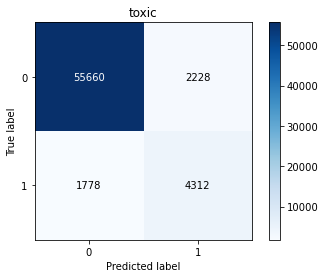

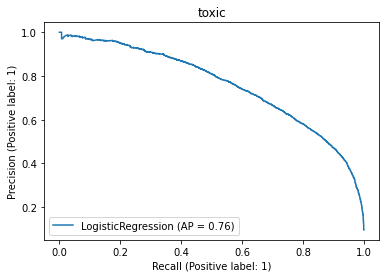

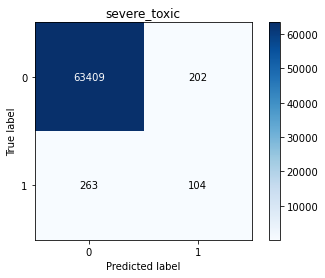

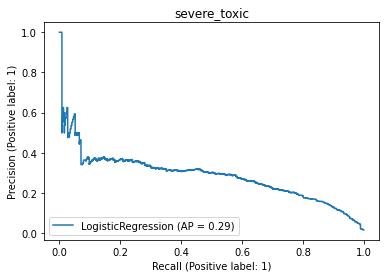

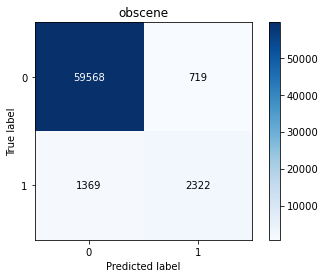

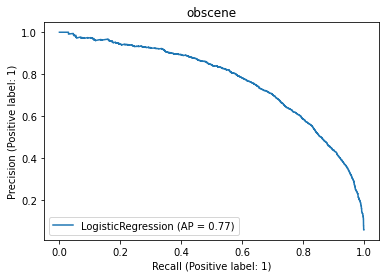

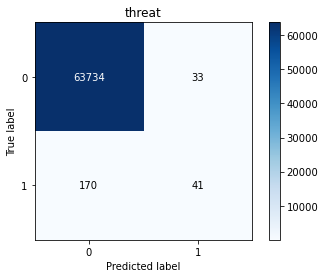

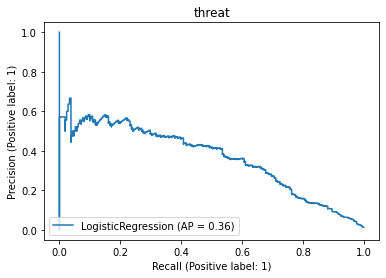

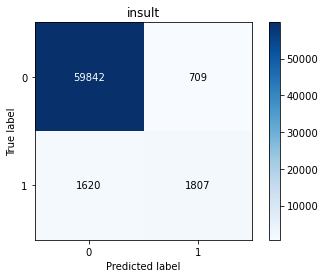

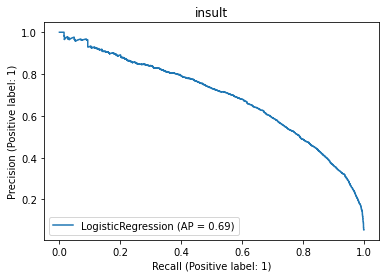

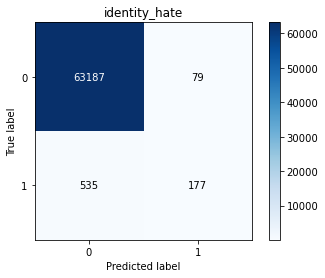

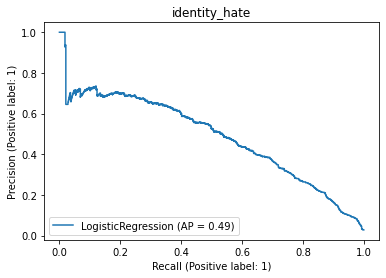

In [114]:
# Check All Tags Predictions using Logistic Regression

for i in tqdm(range(6)):
    lr(y_for_train, y_for_val,i)

C:\Users\LZJ1995\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

This model is to predict  toxic
Linear SVC f1 score: 0.8175518337267396
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     57888
           1       0.59      0.79      0.68      6090

    accuracy                           0.93     63978
   macro avg       0.78      0.87      0.82     63978
weighted avg       0.94      0.93      0.93     63978

This model is to predict  severe_toxic
Linear SVC f1 score: 0.6619451624430583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.35      0.31      0.33       367

    accuracy                           0.99     63978
   macro avg       0.67      0.65      0.66     63978
weighted avg       0.99      0.99      0.99     63978

This model is to predict  obscene
Linear SVC f1 score: 0.8343195494965181
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60287
           1

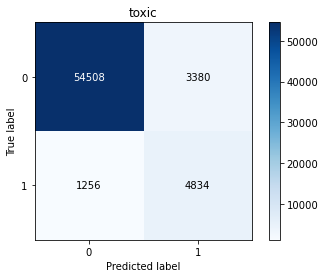

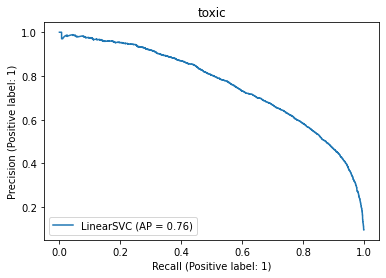

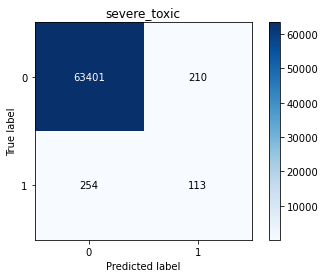

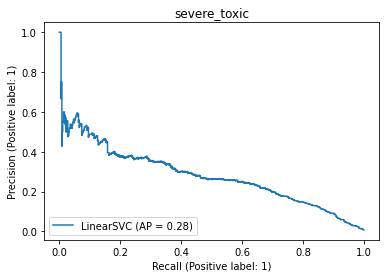

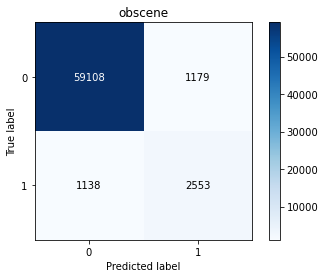

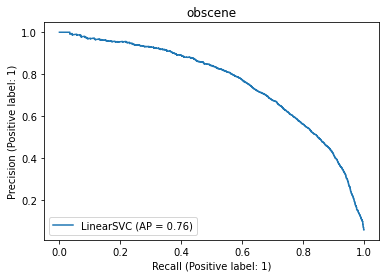

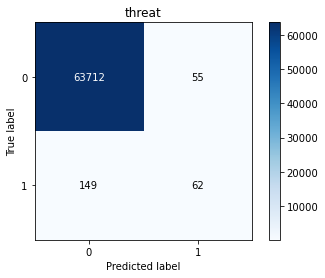

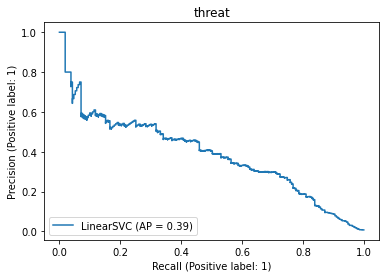

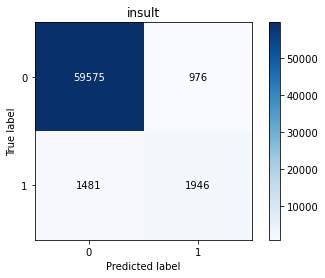

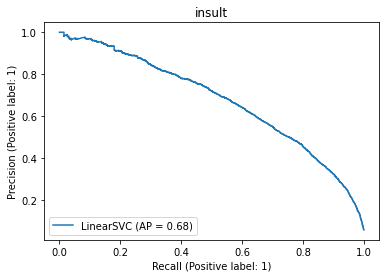

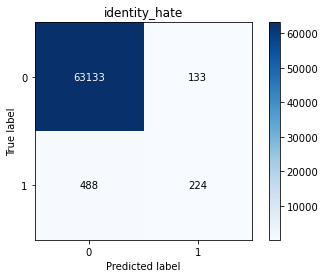

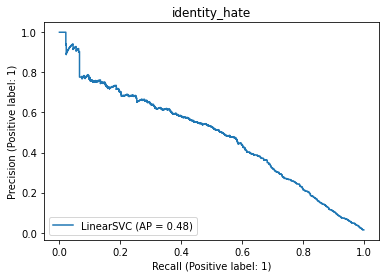

In [115]:
# Check All Tags Predictions using LinearSVC
for i in tqdm(range(6)):
    linearSVC(y_for_train, y_for_val,i)
